In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import bpl
import wcpredictor

/Users/rchan/opt/miniconda3/envs/wcenv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Neutral Model, Use both Fifa organisation and Fifa game ratings

Here is an example with $\xi=0.1$ (default is zero - so no weights) and the weights are computed by having weights $\phi(t)=\gamma \exp(-\xi t)$ where $t$ is the amount of time since `end_date` (so by default this is set to "2022-11-20"), and $\gamma$ is the game weight associated to that (more on that later). This is computed by number of years as a fraction. So a game played on "2022-10-30" has a time difference of 21/365 = 0.057534.

This means that a game that was played on "2022-10-30" has weight $\gamma\exp(-0.1*(21/365))=0.99\gamma$.

A game that is played a full year (365 days) ago, has weight $\gamma\exp(-0.1*(365/365))=0.904\gamma$.

A game that is played a full two years ago has weight $\gamma\exp(-0.2)=0.819\gamma$.

...

For the game weights, we pass in what we pass in how much more weight we should put to World Cup games into `world_cup_weight` argument (the default is one - so no weights). The World Cup weights are then given a weighting `world_cup_weight` and friendlies are given a weight one. The weights for the other competitions,
```
"W": world cup finals,
"C1": top-level continental cup,
"WQ": world cup qualifiers",
"CQ": continental cup qualifiers"
"C2": 2nd-tier continental, e.g. UEFA Nations League,
"F": friendly/other,
```
are then just evenly spaced out in \[1, `world_cup_weight`\]. 

For example, if `world_cup_weight`=5, the corresponding weights are:

`{'F': 1.0, 'C2': 1.8, 'CQ': 2.6, 'WQ': 3.4, 'C1': 4.2, 'W': 5.0}`.

So a *friendly* game that is played on "2022-10-30" has weight $\gamma\exp(-0.1*(21/365))=1.0*0.99 = 0.99$, but if it was a *world cup game*, it would've been assigned a weight $\gamma\exp(-0.1*(21/365))=5.0*0.99 = 4.971$.

In [2]:
# results = wcpredictor.get_results_data(start_date="2018-01-01",
#                                        end_date="2022-11-01")
# fifa_rankings = wcpredictor.get_fifa_rankings_data()
wc_teams = wcpredictor.get_teams_data(year="2022")

# print(f"{sum(results['neutral'])} / {len(results)} games are neutral")

# wc_pred = wcpredictor.WCPred(results = results, ratings=fifa_rankings)

We build a predictor going back to the 2002 World Cup:

In [3]:
wc_pred = wcpredictor.get_and_train_model(rankings_source="both",
                                          start_date = "2002-05-31",
                                          epsilon=0.1,
                                          world_cup_weight=10.0,
                                         )
dict(zip(sorted(list(set(wcpredictor.get_confederations_data()["Confederation"]))),
         wc_pred.model.confederation_strength.mean(axis=0).tolist()))

in get_and_train_model
Using FIFA organisation rankings
Using 16287 rows in training data
Using FIFA videogame rankings
Using FIFA organisation rankings
[MODEL FITTING] Setting training data for the model
[MODEL FITTING] Fitting the model


sample: 100%|██████████████████████████████████████████████| 1500/1500 [22:20<00:00,  1.12it/s, 1023 steps of size 5.14e-03. acc. prob=0.94]


{'AFC': -0.10656991600990295,
 'CAF': 0.15943747758865356,
 'CONCACAF': -0.09306782484054565,
 'CONMEBOL': 0.18138282001018524,
 'OFC': -0.35847485065460205,
 'UEFA': 0.2002609819173813}

## What are the game weights for this example?

In [4]:
wc_pred.epsilon

0.1

In [5]:
wc_pred.world_cup_weight

10.0

In [6]:
wc_pred.weights_dict

{'F': 1.0, 'C2': 2.8, 'CQ': 4.6, 'WQ': 6.4, 'C1': 8.2, 'W': 10.0}

In [7]:
results, weights_dict = wcpredictor.get_results_data(start_date = "2002-05-31",
                                                     world_cup_weight = wc_pred.world_cup_weight)
results["weights"] = np.exp(-wc_pred.epsilon*np.array(results["time_diff"])) * np.array(results["game_weight"])
results

Using FIFA organisation rankings


,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,time_diff,game_weight,weights
0,2002-05-31,France,Senegal,0,1,FIFA World Cup,Seoul,South Korea,True,20.487671,10.0,1.288937
1,2002-06-01,Germany,Saudi Arabia,8,0,FIFA World Cup,Sapporo,Japan,True,20.484932,10.0,1.289290
2,2002-06-01,Republic of Ireland,Cameroon,1,1,FIFA World Cup,Niigata,Japan,True,20.484932,10.0,1.289290
3,2002-06-01,Uruguay,Denmark,1,2,FIFA World Cup,Ulsan,South Korea,True,20.484932,10.0,1.289290
4,2002-06-02,Argentina,Nigeria,1,0,FIFA World Cup,Kashima,Japan,True,20.482192,10.0,1.289644
...,...,...,...,...,...,...,...,...,...,...,...,...
16282,2022-10-22,Saudi Arabia,North Macedonia,1,0,Friendly,Abu Dhabi,United Arab Emirates,True,0.079452,1.0,0.992086
16283,2022-10-23,Qatar,Guatemala,2,0,Friendly,Málaga,Spain,True,0.076712,1.0,0.992358
16284,2022-10-26,Saudi Arabia,Albania,1,1,Friendly,Abu Dhabi,United Arab Emirates,True,0.068493,1.0,0.993174
16285,2022-10-27,Qatar,Honduras,1,0,Friendly,Marbella,Spain,True,0.065753,1.0,0.993446


Looking for first game at 2002 world cup:

In [8]:
results[results["date"]==pd.Timestamp(2002, 5, 31)]

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,time_diff,game_weight,weights
0,2002-05-31,France,Senegal,0,1,FIFA World Cup,Seoul,South Korea,True,20.487671,10.0,1.288937


Looking for first game at 2010 world cup:

In [9]:
results[results["date"]==pd.Timestamp(2010, 6, 11)]

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,time_diff,game_weight,weights
6204,2010-06-11,South Africa,Mexico,1,1,FIFA World Cup,Johannesburg,South Africa,False,12.452055,10.0,2.878817
6205,2010-06-11,Uruguay,France,0,0,FIFA World Cup,Cape Town,South Africa,True,12.452055,10.0,2.878817


Looking for first game at 2014 world cup:

In [10]:
results[results["date"]==pd.Timestamp(2014, 6, 12)]

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,time_diff,game_weight,weights
9426,2014-06-12,Brazil,Croatia,3,1,FIFA World Cup,São Paulo,Brazil,False,8.446575,10.0,4.297045


Looking for first game at 2018 world cup:

In [11]:
results[results["date"]==pd.Timestamp(2018, 6, 14)]

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,time_diff,game_weight,weights
12632,2018-06-14,Russia,Saudi Arabia,5,0,FIFA World Cup,Moscow,Russia,False,4.438356,10.0,6.415709


Looking for the first game of Euro 2020:

In [14]:
results[(results["date"]==pd.Timestamp(2021, 6, 11)) & (results["tournament"]=="UEFA Euro")]

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,time_diff,game_weight,weights
14877,2021-06-11,Italy,Turkey,3,0,UEFA Euro,Rome,Italy,False,1.443836,8.2,7.097557


Looking for the first game of Copa America 2016:

False

In [15]:
results[results["date"]==pd.Timestamp(2016, 6, 3)]

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,time_diff,game_weight,weights
11021,2016-06-03,Albania,Ukraine,1,3,Friendly,Bergamo,Italy,True,6.468493,1.0,0.523693
11022,2016-06-03,Azerbaijan,Canada,1,1,Friendly,Rohrbach an der Lafnitz,Austria,True,6.468493,1.0,0.523693
11023,2016-06-03,Bosnia and Herzegovina,Denmark,2,2,Kirin Cup,Toyota,Japan,True,6.468493,1.0,0.523693
11024,2016-06-03,Myanmar,Singapore,0,1,Friendly,Yangon,Myanmar,False,6.468493,1.0,0.523693
11025,2016-06-03,China PR,Trinidad and Tobago,4,2,Friendly,Qinhuangdao,China PR,False,6.468493,1.0,0.523693
11026,2016-06-03,Djibouti,Tunisia,0,3,African Cup of Nations qualification,Djibouti,Djibouti,False,6.468493,4.6,2.408989
11027,2016-06-03,Faroe Islands,Kosovo,0,2,Friendly,Frankfurt am Main,Germany,True,6.468493,1.0,0.523693
11028,2016-06-03,Japan,Bulgaria,7,2,Kirin Cup,Toyota,Japan,False,6.468493,1.0,0.523693
11029,2016-06-03,Libya,Morocco,1,1,African Cup of Nations qualification,Radès,Tunisia,True,6.468493,4.6,2.408989
11030,2016-06-03,Mauritania,Cameroon,0,1,African Cup of Nations qualification,Nouakchott,Mauritania,False,6.468493,4.6,2.408989


## What are the estimated parameters?

In [16]:
wc_teams_idx = {team: idx for idx, team in enumerate(wc_pred.model.teams)
                if team in wc_teams["Team"].values}

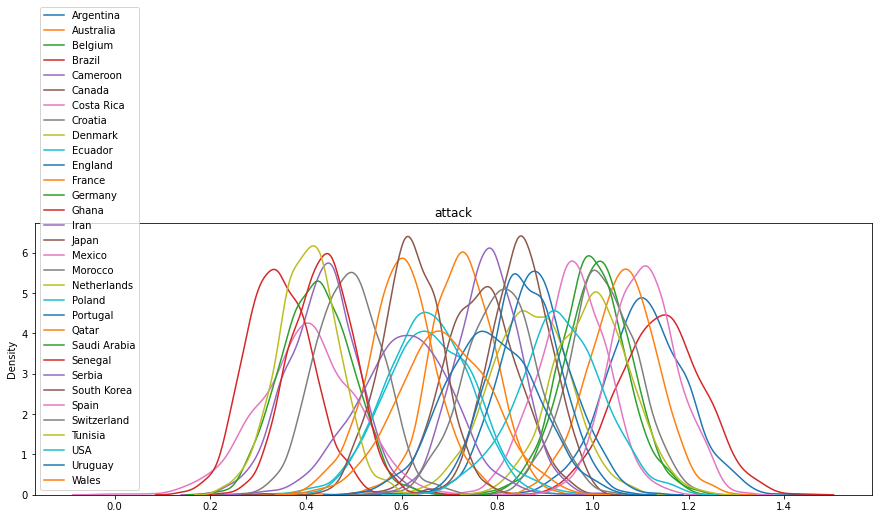

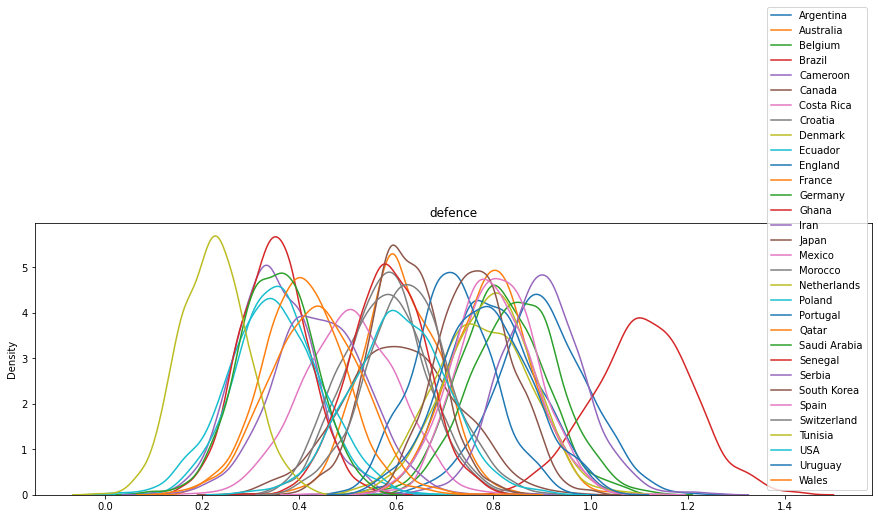

In [17]:
ax = plt.figure(figsize=(15, 5)).gca()
for team, idx in wc_teams_idx.items():
    sns.kdeplot(wc_pred.model.attack[:, idx], label=team)
plt.title('attack')
plt.legend()

ax = plt.figure(figsize=(15, 5)).gca()
for team, idx in wc_teams_idx.items():
    sns.kdeplot(wc_pred.model.defence[:, idx], label=team)
plt.title('defence')
plt.legend()

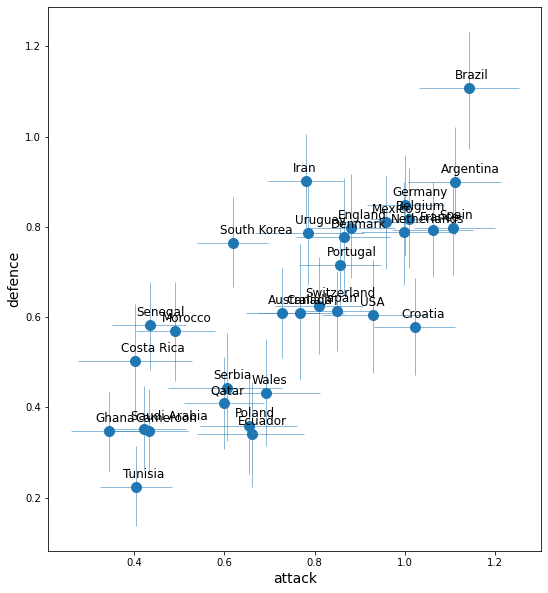

In [18]:
a_mean = wc_pred.model.attack.mean(axis=0)
b_mean = wc_pred.model.defence.mean(axis=0)

a_conf95 = np.abs(np.quantile(wc_pred.model.attack,[0.025, 0.975], axis=0) - a_mean)
b_conf95 = np.abs(np.quantile(wc_pred.model.defence, [0.025, 0.975], axis=0) - b_mean)
a_conf80 = np.abs(np.quantile(wc_pred.model.attack,[0.1, 0.9], axis=0) - a_mean)
b_conf80 = np.abs(np.quantile(wc_pred.model.defence, [0.1, 0.9], axis=0) - b_mean)

fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.set_aspect('equal')
select_idx = np.array(list(wc_teams_idx.values()), dtype=int)
plt.errorbar(a_mean[select_idx],
             b_mean[select_idx],
             xerr=a_conf80[:, select_idx],
             yerr=b_conf80[:, select_idx],
             marker='o', markersize=10,
             linestyle='', linewidth=0.5)
plt.xlabel('attack', fontsize=14)
plt.ylabel('defence', fontsize=14)

for team, idx in wc_teams_idx.items():
    ax.annotate(team,
                (a_mean[idx]-0.03, b_mean[idx]+0.02), 
                fontsize=12)

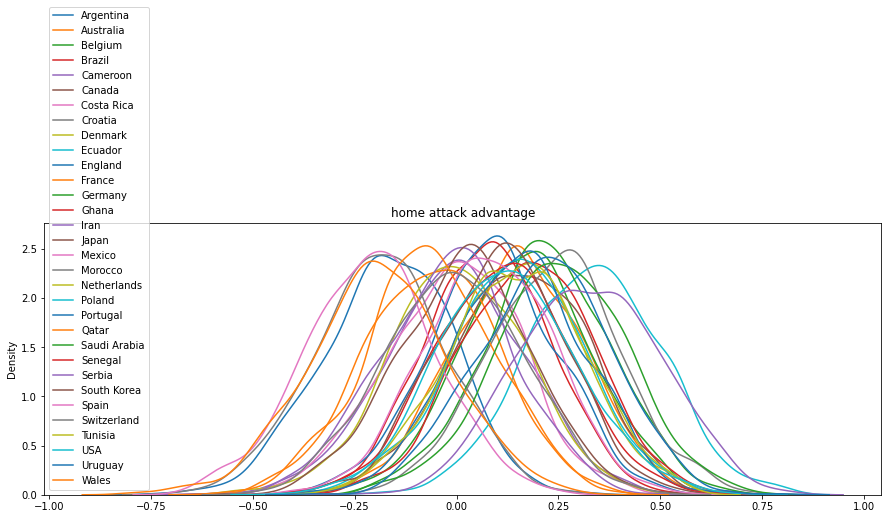

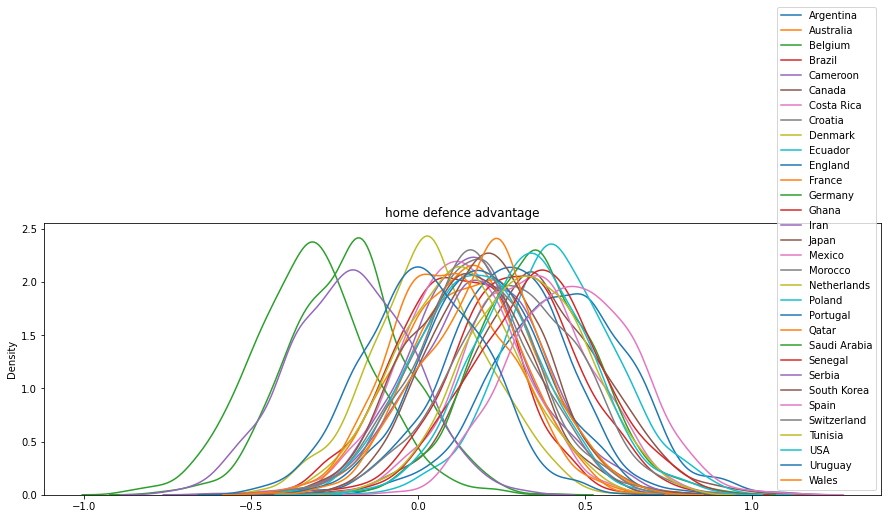

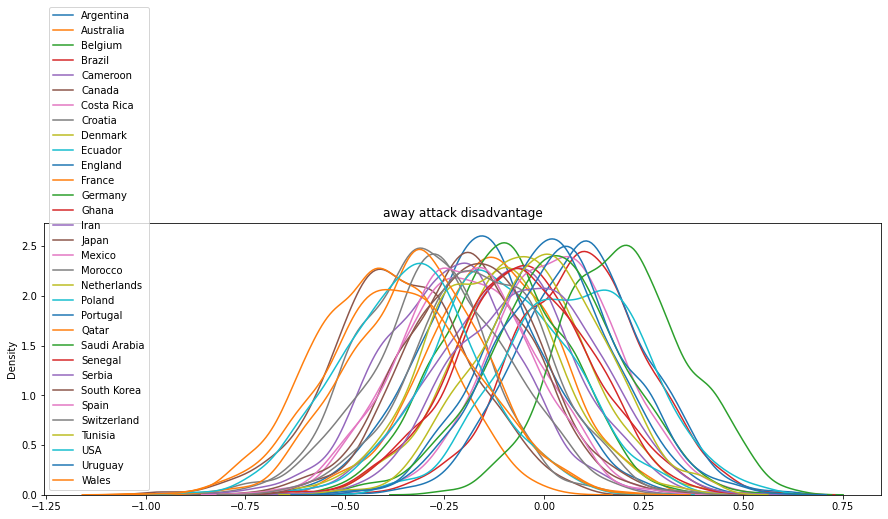

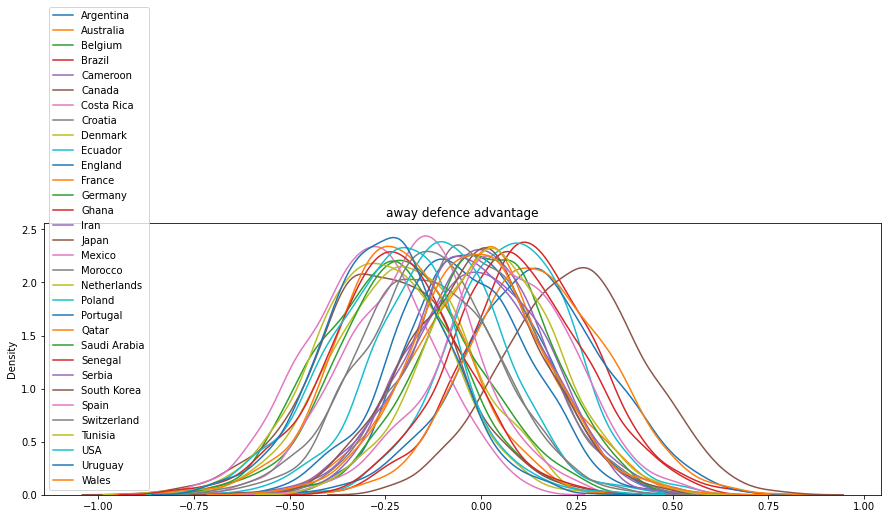

In [19]:
ax = plt.figure(figsize=(15, 5)).gca()
for team, idx in wc_teams_idx.items():
    sns.kdeplot(wc_pred.model.home_attack[:, idx], label=team)
plt.title('home attack advantage')
plt.legend()

ax = plt.figure(figsize=(15, 5)).gca()
for team, idx in wc_teams_idx.items():
    sns.kdeplot(wc_pred.model.home_defence[:, idx], label=team)
plt.title('home defence advantage')
plt.legend()

ax = plt.figure(figsize=(15, 5)).gca()
for team, idx in wc_teams_idx.items():
    sns.kdeplot(wc_pred.model.away_attack[:, idx], label=team)
plt.title('away attack disadvantage')
plt.legend()

ax = plt.figure(figsize=(15, 5)).gca()
for team, idx in wc_teams_idx.items():
    sns.kdeplot(wc_pred.model.away_defence[:, idx], label=team)
plt.title('away defence advantage')
plt.legend()

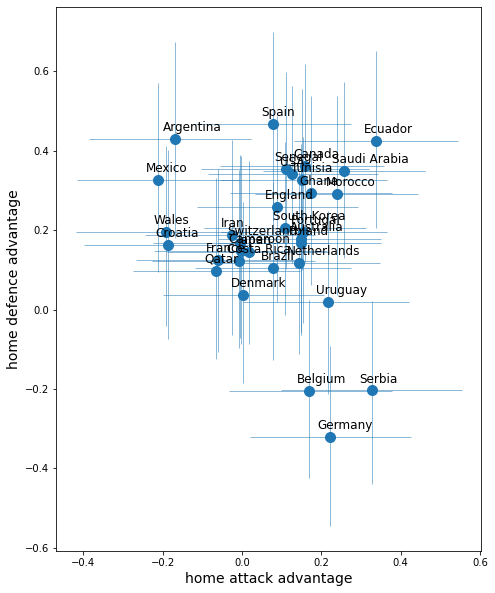

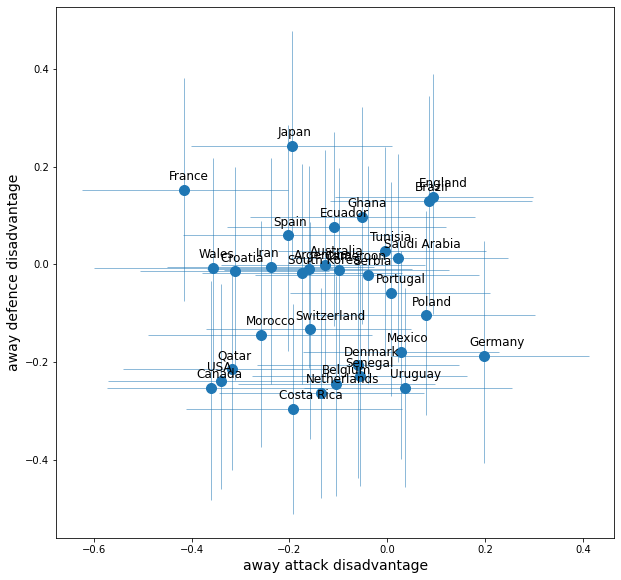

In [20]:
a_mean = wc_pred.model.home_attack.mean(axis=0)
b_mean = wc_pred.model.home_defence.mean(axis=0)

a_conf95 = np.abs(np.quantile(wc_pred.model.home_attack,[0.025, 0.975], axis=0) - a_mean)
b_conf95 = np.abs(np.quantile(wc_pred.model.home_defence, [0.025, 0.975], axis=0) - b_mean)
a_conf80 = np.abs(np.quantile(wc_pred.model.home_attack,[0.1, 0.9], axis=0) - a_mean)
b_conf80 = np.abs(np.quantile(wc_pred.model.home_defence, [0.1, 0.9], axis=0) - b_mean)

fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.set_aspect('equal')
select_idx = np.array(list(wc_teams_idx.values()), dtype=int)
plt.errorbar(a_mean[select_idx],
             b_mean[select_idx],
             xerr=a_conf80[:, select_idx],
             yerr=b_conf80[:, select_idx],
             marker='o', markersize=10,
             linestyle='', linewidth=0.5)
plt.xlabel('home attack advantage', fontsize=14)
plt.ylabel('home defence advantage', fontsize=14)

for team, idx in wc_teams_idx.items():
    ax.annotate(team,
                (a_mean[idx]-0.03, b_mean[idx]+0.02), 
                fontsize=12)

    
    
a_mean = wc_pred.model.away_attack.mean(axis=0)
b_mean = wc_pred.model.away_defence.mean(axis=0)

a_conf95 = np.abs(np.quantile(wc_pred.model.away_attack,[0.025, 0.975], axis=0) - a_mean)
b_conf95 = np.abs(np.quantile(wc_pred.model.away_defence, [0.025, 0.975], axis=0) - b_mean)
a_conf80 = np.abs(np.quantile(wc_pred.model.away_attack,[0.1, 0.9], axis=0) - a_mean)
b_conf80 = np.abs(np.quantile(wc_pred.model.away_defence, [0.1, 0.9], axis=0) - b_mean)

fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.set_aspect('equal')
select_idx = np.array(list(wc_teams_idx.values()), dtype=int)
plt.errorbar(a_mean[select_idx],
             b_mean[select_idx],
             xerr=a_conf80[:, select_idx],
             yerr=b_conf80[:, select_idx],
             marker='o', markersize=10,
             linestyle='', linewidth=0.5)
plt.xlabel('away attack disadvantage', fontsize=14)
plt.ylabel('away defence disadvantage', fontsize=14)

for team, idx in wc_teams_idx.items():
    ax.annotate(team,
                (a_mean[idx]-0.03, b_mean[idx]+0.02), 
                fontsize=12)


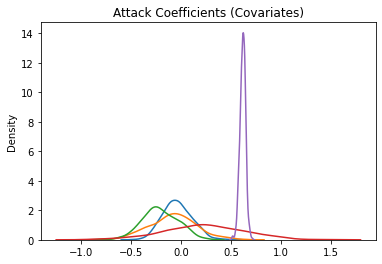

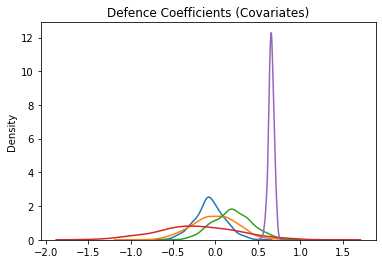

In [21]:
if wc_pred.model.attack_coefficients is not None:
    plt.figure()
    for i in range(wc_pred.model.attack_coefficients.shape[1]):
        sns.kdeplot(wc_pred.model.attack_coefficients[:, i])
    plt.title("Attack Coefficients (Covariates)")

    plt.figure()
    for i in range(wc_pred.model.defence_coefficients.shape[1]):
        sns.kdeplot(wc_pred.model.defence_coefficients[:, i])
    plt.title("Defence Coefficients (Covariates)")

## Using organisation rankings

In [9]:
wc_pred = wcpredictor.get_and_train_model(rankings_source="org")
dict(zip(sorted(list(set(wcpredictor.get_confederations_data()["Confederation"]))),
         wc_pred.model.confederation_strength.mean(axis=0).tolist()))

in get_and_train_model
Using FIFA organisation rankings
Using 3728 rows in training data
Using FIFA organisation rankings
[MODEL FITTING] Setting training data for the model
[MODEL FITTING] Fitting the model


sample: 100%|████████████████████████████████████████████████| 1500/1500 [00:20<00:00, 72.16it/s, 31 steps of size 1.97e-01. acc. prob=0.86]


{'AFC': -0.028468484058976173,
 'CAF': 0.07648350298404694,
 'CONCACAF': -0.08903396874666214,
 'CONMEBOL': 0.09851432591676712,
 'OFC': -0.1488683819770813,
 'UEFA': 0.11657358705997467}

In [10]:
wc_pred.model.home

DeviceArray([[0.22193925, 0.2523736 , 0.2236507 , ..., 0.30747578,
              0.23764938, 0.2970705 ],
             [0.29269314, 0.29989433, 0.30209374, ..., 0.2762314 ,
              0.29821798, 0.29000682],
             [0.2270871 , 0.20911045, 0.22952041, ..., 0.25616747,
              0.22663628, 0.22035587],
             ...,
             [0.38840625, 0.09615856, 0.22842708, ..., 0.2958744 ,
              0.24707505, 0.3418502 ],
             [0.37854502, 0.10997349, 0.18473202, ..., 0.28846854,
              0.26057872, 0.31365734],
             [0.20533201, 0.41776624, 0.32817078, ..., 0.20194647,
              0.34725064, 0.17501424]], dtype=float32)

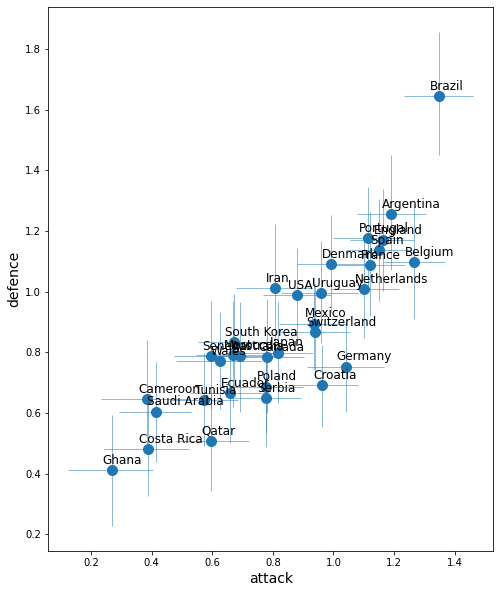

In [11]:
wc_teams_idx = {team: idx for idx, team in enumerate(wc_pred.model.teams)
                if team in wc_teams["Team"].values}
a_mean = wc_pred.model.attack.mean(axis=0)
b_mean = wc_pred.model.defence.mean(axis=0)

a_conf95 = np.abs(np.quantile(wc_pred.model.attack,[0.025, 0.975], axis=0) - a_mean)
b_conf95 = np.abs(np.quantile(wc_pred.model.defence, [0.025, 0.975], axis=0) - b_mean)
a_conf80 = np.abs(np.quantile(wc_pred.model.attack,[0.1, 0.9], axis=0) - a_mean)
b_conf80 = np.abs(np.quantile(wc_pred.model.defence, [0.1, 0.9], axis=0) - b_mean)

fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.set_aspect('equal')
select_idx = np.array(list(wc_teams_idx.values()), dtype=int)
plt.errorbar(a_mean[select_idx],
             b_mean[select_idx],
             xerr=a_conf80[:, select_idx],
             yerr=b_conf80[:, select_idx],
             marker='o', markersize=10,
             linestyle='', linewidth=0.5)
plt.xlabel('attack', fontsize=14)
plt.ylabel('defence', fontsize=14)

for team, idx in wc_teams_idx.items():
    ax.annotate(team,
                (a_mean[idx]-0.03, b_mean[idx]+0.02), 
                fontsize=12)

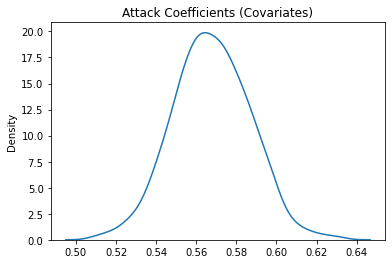

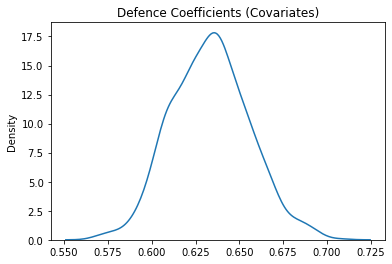

In [12]:
if wc_pred.model.attack_coefficients is not None:
    plt.figure()
    for i in range(wc_pred.model.attack_coefficients.shape[1]):
        sns.kdeplot(wc_pred.model.attack_coefficients[:, i])
    plt.title("Attack Coefficients (Covariates)")

    plt.figure()
    for i in range(wc_pred.model.defence_coefficients.shape[1]):
        sns.kdeplot(wc_pred.model.defence_coefficients[:, i])
    plt.title("Defence Coefficients (Covariates)")

## Use Fifa game ratings

In [3]:
wc_pred = wcpredictor.get_and_train_model(rankings_source="game")
dict(zip(sorted(list(set(wcpredictor.get_confederations_data()["Confederation"]))),
         wc_pred.model.confederation_strength.mean(axis=0).tolist()))

in get_and_train_model
Using FIFA organisation rankings
Using 6901 rows in training data
Using FIFA videogame rankings
Using FIFA organisation rankings
[MODEL FITTING] Setting training data for the model
[MODEL FITTING] Fitting the model


warmup:   3%|█▎                                            | 42/1500 [06:30<3:46:12,  9.31s/it, 1023 steps of size 2.34e-03. acc. prob=0.72]


KeyboardInterrupt: 

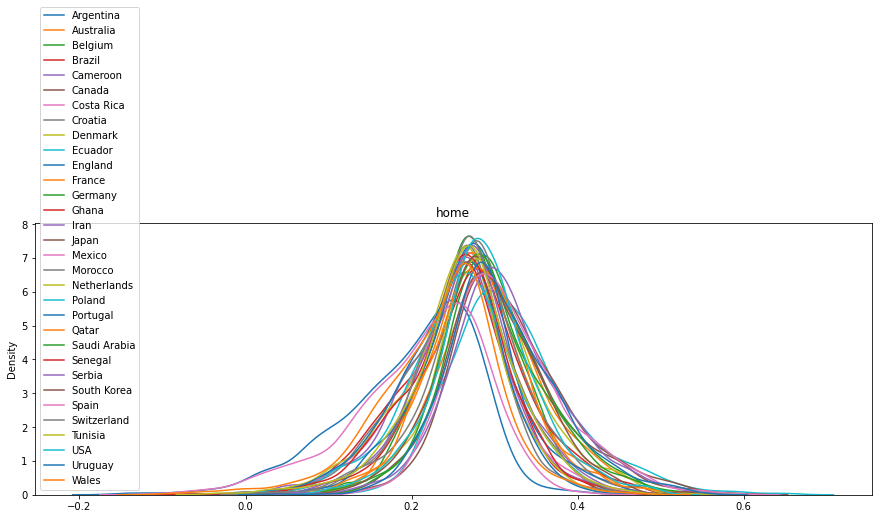

In [62]:
ax = plt.figure(figsize=(15, 5)).gca()
for team, idx in wc_teams_idx.items():
    sns.kdeplot(wc_pred.model.home[:, idx], label=team)
plt.title('home')
plt.legend()

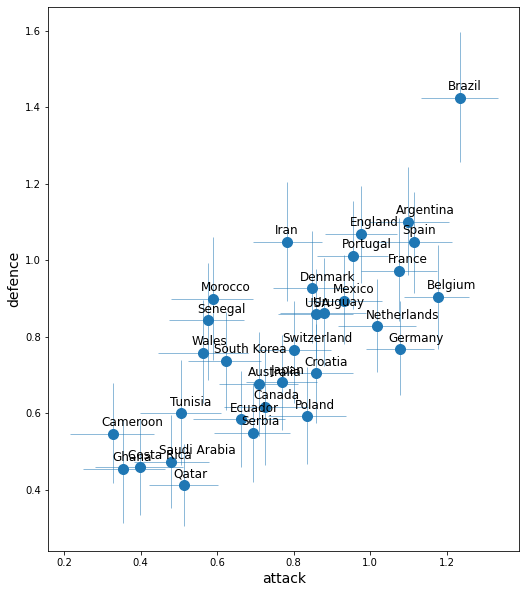

In [63]:
wc_teams_idx = {team: idx for idx, team in enumerate(wc_pred.model.teams)
                if team in wc_teams["Team"].values}
a_mean = wc_pred.model.attack.mean(axis=0)
b_mean = wc_pred.model.defence.mean(axis=0)

a_conf95 = np.abs(np.quantile(wc_pred.model.attack,[0.025, 0.975], axis=0) - a_mean)
b_conf95 = np.abs(np.quantile(wc_pred.model.defence, [0.025, 0.975], axis=0) - b_mean)
a_conf80 = np.abs(np.quantile(wc_pred.model.attack,[0.1, 0.9], axis=0) - a_mean)
b_conf80 = np.abs(np.quantile(wc_pred.model.defence, [0.1, 0.9], axis=0) - b_mean)

fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.set_aspect('equal')
select_idx = np.array(list(wc_teams_idx.values()), dtype=int)
plt.errorbar(a_mean[select_idx],
             b_mean[select_idx],
             xerr=a_conf80[:, select_idx],
             yerr=b_conf80[:, select_idx],
             marker='o', markersize=10,
             linestyle='', linewidth=0.5)
plt.xlabel('attack', fontsize=14)
plt.ylabel('defence', fontsize=14)

for team, idx in wc_teams_idx.items():
    ax.annotate(team,
                (a_mean[idx]-0.03, b_mean[idx]+0.02), 
                fontsize=12)

In [17]:
results

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,2018-06-02,El Salvador,Honduras,1,0,Friendly,Houston,USA,True
1,2018-06-02,Thailand,China PR,0,2,Friendly,Bangkok,Thailand,False
2,2018-06-02,England,Nigeria,2,1,Friendly,London,England,False
3,2018-06-02,Montenegro,Slovenia,0,2,Friendly,Podgorica,Montenegro,False
4,2018-06-02,Mexico,Scotland,1,0,Friendly,Mexico City,Mexico,False
...,...,...,...,...,...,...,...,...,...
3723,2022-10-22,Saudi Arabia,North Macedonia,1,0,Friendly,Abu Dhabi,United Arab Emirates,True
3724,2022-10-23,Qatar,Guatemala,2,0,Friendly,Málaga,Spain,True
3725,2022-10-26,Saudi Arabia,Albania,1,1,Friendly,Abu Dhabi,United Arab Emirates,True
3726,2022-10-27,Qatar,Honduras,1,0,Friendly,Marbella,Spain,True


In [46]:
results = wcpredictor.get_results_data(start_date="2002-06-01")

Using FIFA organisation rankings


In [47]:
Brazil = results[(results["home_team"]=="Brazil") | (results["away_team"]=="Brazil")]

In [48]:
Brazil

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
4,2002-06-03,Brazil,Turkey,2,1,FIFA World Cup,Ulsan,South Korea,True
20,2002-06-08,Brazil,China PR,4,0,FIFA World Cup,Seogwipo,South Korea,True
39,2002-06-13,Costa Rica,Brazil,2,5,FIFA World Cup,Suwon,South Korea,True
51,2002-06-17,Brazil,Belgium,2,0,FIFA World Cup,Kobe,Japan,True
55,2002-06-21,England,Brazil,1,2,FIFA World Cup,Fukuroi,Japan,True
...,...,...,...,...,...,...,...,...,...
15809,2022-03-29,Bolivia,Brazil,0,4,FIFA World Cup qualification,La Paz,Bolivia,False
15906,2022-06-02,South Korea,Brazil,1,5,Friendly,Seoul,South Korea,False
15979,2022-06-06,Japan,Brazil,0,1,Friendly,Tokyo,Japan,False
16170,2022-09-23,Brazil,Ghana,3,0,Friendly,Le Havre,France,True


In [49]:
home_goals_scored = Brazil[Brazil["home_team"]=="Brazil"]["home_score"].sum()
home_goals_conceded = Brazil[Brazil["home_team"]=="Brazil"]["away_score"].sum()
away_goals_scored = Brazil[Brazil["away_team"]=="Brazil"]["away_score"].sum()
away_goals_conceded = Brazil[Brazil["away_team"]=="Brazil"]["home_score"].sum()
home_goals_scored - home_goals_conceded + away_goals_scored - away_goals_conceded

389

In [50]:
home_goals_scored

307

In [51]:
home_goals_conceded

84

In [52]:
away_goals_scored

251

In [53]:
away_goals_conceded

85

In [54]:
sum(Brazil[Brazil["home_team"]=="Brazil"]["home_score"] > Brazil[Brazil["home_team"]=="Brazil"]["away_score"]) / len(Brazil[Brazil["home_team"]=="Brazil"])

0.7183098591549296

In [55]:
sum(Brazil[Brazil["away_team"]=="Brazil"]["away_score"] > Brazil[Brazil["away_team"]=="Brazil"]["home_score"]) / len(Brazil[Brazil["away_team"]=="Brazil"])


0.6

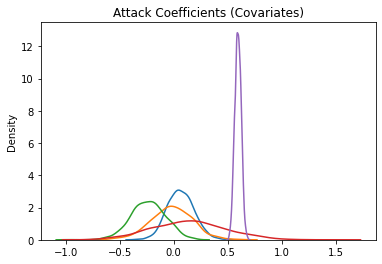

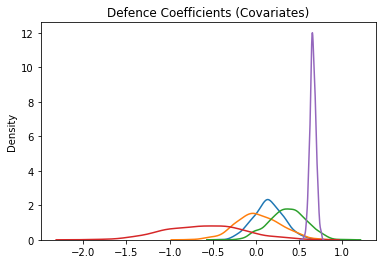

In [20]:
if wc_pred.model.attack_coefficients is not None:
    plt.figure()
    for i in range(wc_pred.model.attack_coefficients.shape[1]):
        sns.kdeplot(wc_pred.model.attack_coefficients[:, i])
    plt.title("Attack Coefficients (Covariates)")

    plt.figure()
    for i in range(wc_pred.model.defence_coefficients.shape[1]):
        sns.kdeplot(wc_pred.model.defence_coefficients[:, i])
    plt.title("Defence Coefficients (Covariates)")

In [3]:
results = wcpredictor.get_results_data(start_date="2002-06-01")

Using FIFA organisation rankings


DeviceArray([0.97972614, 0.97972614, 0.97972614, ..., 0.9999315 ,
             0.99993426, 0.9999425 ], dtype=float32)

In [80]:

from datetime import timedelta

In [4]:
import os
import json
import pandas as pd
from typing import Optional, Union, List, Tuple, Dict

def get_results_data(
        start_date: str = "2018-06-01",
        end_date: str = "2022-11-20",
        competitions: List[str] = ["W","C1","WQ","CQ","C2","F"]
) -> pd.DataFrame:
    """
    filter the results dataframe by date and competition.
    Key for competitions:
    "W": world cup finals,
    "C1": top-level continental cup,
    "WQ": world cup qualifiers",
    "CQ": continental cup qualifiers"
    "C2": 2nd-tier continental, e.g. UEFA Nations League,
    "F": friendly/other.
    """
    csv_path = "../wcpredictor/data/results.csv"
    results_df = pd.read_csv(csv_path,parse_dates=['date'])
    # get an index of what competition is in what category
    json_path = "../wcpredictor/data/competition_index.json"
    competitions_index = json.load(open(json_path))
    # filter by date
    results_df = results_df[(results_df.date > start_date) &
                            (results_df.date < end_date)]
    # replace any names that we have written differently elsewhere
    results_df.replace("United States", "USA", inplace=True)
    # filter matches with non-fifa recognised teams
    rankings_df = wcpredictor.get_fifa_rankings_data("org")
    fifa_teams = (rankings_df.Team.values)
    results_df = results_df[(results_df.home_team.isin(fifa_teams)) &
                            (results_df.away_team.isin(fifa_teams))]
    # filter by competition
    comp_filter = [competitions_index[comp] for comp in competitions]
    # flatten this nested list
    comp_filter = [comp for complist in comp_filter for comp in complist]
    results_df = results_df[results_df.tournament.isin(comp_filter)]
    # obtain time difference to the latest date in the dataframe
    end_date = results_df.date.max()
    results_df["time_diff"] = (end_date-results_df.date) / pd.Timedelta(days=365)

    results_df = results_df.reset_index(drop=True)
    return results_df

In [5]:
results = get_results_data(start_date="2002-06-01")

Using FIFA organisation rankings


In [14]:
import math
end_date = results.date.max()
(end_date-results.date).dt.days

0        7455
1        7455
2        7455
3        7455
4        7454
         ... 
16278       8
16279       7
16280       4
16281       3
16282       0
Name: date, Length: 16283, dtype: int64

In [94]:
results[results["date"] > pd.Timestamp("2020")]

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,time_diff
14206,2020-01-07,Barbados,Canada,1,4,Friendly,Irvine,USA,True,2.813699
14207,2020-01-09,Moldova,Sweden,0,1,Friendly,Doha,Qatar,True,2.808219
14208,2020-01-10,Barbados,Canada,1,4,Friendly,Irvine,USA,True,2.805479
14209,2020-01-12,Kosovo,Sweden,0,1,Friendly,Doha,Qatar,True,2.800000
14210,2020-01-15,Canada,Iceland,0,1,Friendly,Irvine,USA,True,2.791781
...,...,...,...,...,...,...,...,...,...,...
16278,2022-10-22,Saudi Arabia,North Macedonia,1,0,Friendly,Abu Dhabi,United Arab Emirates,True,0.021918
16279,2022-10-23,Qatar,Guatemala,2,0,Friendly,Málaga,Spain,True,0.019178
16280,2022-10-26,Saudi Arabia,Albania,1,1,Friendly,Abu Dhabi,United Arab Emirates,True,0.010959
16281,2022-10-27,Qatar,Honduras,1,0,Friendly,Marbella,Spain,True,0.008219


# trying to hack away at Fifa default rankings for teams

In [16]:
confed_dict = dict(zip(wcpredictor.get_confederations_data().Team,
         wcpredictor.get_confederations_data().Confederation))
csv_path = "../wcpredictor/data/fifa_game_rankings.csv"
df =  pd.read_csv(csv_path)
# assign default values to teams not otherwise covered, use the same as Qatar
default_row = df.loc[df.Team=="Qatar"]
all_teams = wcpredictor.get_confederations_data().Team.unique()
current_teams = df.Team.unique()
new_teams = list(set(all_teams) - set(current_teams))

In [17]:
[team for team in new_teams if confed_dict[team] == "UEFA"]

['Belarus',
 'Slovenia',
 'Andorra',
 'Estonia',
 'Kosovo',
 'Latvia',
 'Moldova',
 'Turkey',
 'Luxembourg',
 'Slovakia',
 'Montenegro',
 'Bosnia and Herzegovina',
 'Malta',
 'San Marino',
 'Gibraltar',
 'Lithuania',
 'Greece',
 'Faroe Islands',
 'Azerbaijan',
 'Liechtenstein',
 'Russia',
 'Cyprus',
 'Israel',
 'Georgia',
 'Armenia',
 'North Macedonia',
 'Bulgaria',
 'Albania']

In [18]:
[team for team in new_teams if confed_dict[team] == "CONMEBOL"]

['Paraguay', 'Colombia', 'Bolivia', 'Venezuela']

In [ ]:
for conference in ["UEFA", "CAF"]:
    teams_in_conf = [team for team in new_teams if confed_dict[team] == conference]
    if conference == "UEFA":
        attribute = 2
    attack = 

In [45]:
test = []
test += [1,2]

In [46]:
test

[1, 2]

In [38]:
[team for team in new_teams if confed_dict[team] == "CAF"]

['Eritrea',
 'Somalia',
 'Burkina Faso',
 'São Tomé and Príncipe',
 'Benin',
 'Rwanda',
 'Liberia',
 'Malawi',
 'Sudan',
 'Kenya',
 'Guinea-Bissau',
 'Zimbabwe',
 'South Africa',
 'Botswana',
 'Mozambique',
 'Uganda',
 'Angola',
 'Gabon',
 'Ivory Coast',
 'Eswatini',
 'Niger',
 'Mauritius',
 'Togo',
 'Seychelles',
 'Libya',
 'Madagascar',
 'Mali',
 'Egypt',
 'Burundi',
 'Nigeria',
 'DR Congo',
 'Chad',
 'Central African Republic',
 'Algeria',
 'Comoros',
 'Equatorial Guinea',
 'Mauritania',
 'Tanzania',
 'Djibouti',
 'Cape Verde',
 'Lesotho',
 'South Sudan',
 'Sierra Leone',
 'Namibia',
 'Guinea',
 'Ethiopia',
 'Zambia',
 'Congo',
 'Gambia']

In [39]:
[team for team in new_teams if confed_dict[team] == "AFC"]

['Vietnam',
 'Guam',
 'Kyrgyzstan',
 'United Arab Emirates',
 'Bahrain',
 'Palestine',
 'Iraq',
 'Kazakhstan',
 'Syria',
 'Turkmenistan',
 'Tajikistan',
 'Bhutan',
 'Hong Kong',
 'North Korea',
 'Malaysia',
 'Maldives',
 'Philippines',
 'Pakistan',
 'Laos',
 'Cambodia',
 'Timor-Leste',
 'Yemen',
 'Bangladesh',
 'Mongolia',
 'Afghanistan',
 'Sri Lanka',
 'Oman',
 'Kuwait',
 'Indonesia',
 'Lebanon',
 'Thailand',
 'India',
 'Nepal',
 'Brunei Darussalam',
 'Jordan',
 'Taiwan',
 'Myanmar',
 'Macau',
 'Singapore',
 'Uzbekistan']

In [14]:
[team for team in new_teams if confed_dict[team] == "AFC"]

['Mongolia',
 'Kuwait',
 'Lebanon',
 'Philippines',
 'Bahrain',
 'Nepal',
 'Kyrgyzstan',
 'Taiwan',
 'Maldives',
 'Brunei Darussalam',
 'India',
 'United Arab Emirates',
 'Iraq',
 'Bangladesh',
 'Myanmar',
 'Malaysia',
 'Cambodia',
 'Timor-Leste',
 'Yemen',
 'Sri Lanka',
 'Jordan',
 'Uzbekistan',
 'Bhutan',
 'Macau',
 'Hong Kong',
 'Pakistan',
 'Laos',
 'Tajikistan',
 'Afghanistan',
 'Guam',
 'Thailand',
 'Turkmenistan',
 'Vietnam',
 'Syria',
 'North Korea',
 'Singapore',
 'Palestine',
 'Kazakhstan',
 'Indonesia',
 'Oman']

In [41]:
df.loc[df.Team=="China PR"]

,Team,Attack,Midfield,Defence,Overall
46,China PR,68,68,67,68


In [ ]:
pd.DataFrame({a})

In [36]:
len(new_teams)

164

In [34]:
pd.Series([confed_dict[team] for team in new_teams]).value_counts()

CAF         49
AFC         40
CONCACAF    31
UEFA        28
OFC         10
CONMEBOL     6
dtype: int64

In [ ]:
# need to give the "worst" team in their conference

In [ ]:
self.conferences_ref = dict(zip(range(len(self.conferences)), self.conferences))

In [26]:
wcpredictor.get_confederations_data()

,Team,Confederation
0,India,AFC
1,Thailand,AFC
2,North Korea,AFC
3,Kazakhstan,AFC
4,Philippines,AFC
...,...,...
206,Moldova,UEFA
207,Hungary,UEFA
208,Azerbaijan,UEFA
209,Netherlands,UEFA


In [42]:
set(wcpredictor.get_confederations_data().Confederation)

{'AFC', 'CAF', 'CONCACAF', 'CONMEBOL', 'OFC', 'UEFA'}

In [9]:
confed_dict["Estonia"]

'UEFA'

## Dynamic Model

In [11]:
def add_gameweek_index(df):
    earliest_date = df["date"].min()
    latest_date = df["date"].max()
    month, year = earliest_date.month, earliest_date.year
    end_month, end_year = latest_date.month, latest_date.year
    gameweek_index = 1
    while pd.Timestamp(f"{year}-{month}-01") <= latest_date:
        month_cond = df["date"].dt.month == month
        year_cond = df["date"].dt.year == year
        df.loc[month_cond & year_cond, "gameweek"] = gameweek_index
        if month < 12:
            month += 1
        else:
            month = 1
            year += 1
        gameweek_index += 1
    df["gameweek"] = df["gameweek"].astype(int)
    return df

results = add_gameweek_index(results)

In [12]:
wc_pred = wcpredictor.WCPred(results = results, ratings=fifa_rankings)

In [13]:
wc_pred.fit_model(dynamic=True)

[MODEL FITTING] Setting training data for the model
[MODEL FITTING] Fitting the model


sample:  82%|█████████████████████████████████████▉        | 1237/1500 [33:36<07:08,  1.63s/it, 1023 steps of size 5.45e-04. acc. prob=0.83]


KeyboardInterrupt: 

In [ ]:
wc_teams_idx = {team: idx for idx, team in enumerate(wc_pred.model.teams)
                if team in wc_teams["Team"].values}

In [ ]:
wc_pred.model.attack[51]

In [ ]:
ax = plt.figure(figsize=(15, 5)).gca()
for team, idx in wc_teams_idx.items():
    sns.kdeplot(wc_pred.model.attack[56][:, idx], label=team)
plt.title('attack')
plt.legend()

ax = plt.figure(figsize=(15, 5)).gca()
for team, idx in wc_teams_idx.items():
    sns.kdeplot(wc_pred.model.defence[56][:, idx], label=team)
plt.title('defence')
plt.legend()

In [ ]:
a_mean = wc_pred.model.attack[56].mean(axis=0)
b_mean = wc_pred.model.defence[56].mean(axis=0)

a_conf95 = np.abs(np.quantile(wc_pred.model.attack[56],[0.025, 0.975], axis=0) - a_mean)
b_conf95 = np.abs(np.quantile(wc_pred.model.defence[56], [0.025, 0.975], axis=0) - b_mean)
a_conf80 = np.abs(np.quantile(wc_pred.model.attack[56],[0.1, 0.9], axis=0) - a_mean)
b_conf80 = np.abs(np.quantile(wc_pred.model.defence[56], [0.1, 0.9], axis=0) - b_mean)

fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.set_aspect('equal')
select_idx = np.array(list(wc_teams_idx.values()), dtype=int)
plt.errorbar(a_mean[select_idx],
             b_mean[select_idx],
             xerr=a_conf80[:, select_idx],
             yerr=b_conf80[:, select_idx],
             marker='o', markersize=10,
             linestyle='', linewidth=0.5)
plt.xlabel('attack', fontsize=14)
plt.ylabel('defence', fontsize=14)

for team, idx in wc_teams_idx.items():
    ax.annotate(team,
                (a_mean[idx]-0.03, b_mean[idx]+0.02), 
                fontsize=12)

## Try Including More Years (but without FIFA rankings)

- fit up to end of 2020
- test on 2021 and 2022

In [45]:
results = pd.read_csv('../data/results.csv', parse_dates=['date'])
results.rename(columns={"neutral": "neutral_venue"}, inplace=True)


def filter_results(year_from, year_until, teams=None):
    r = results[(results.date.dt.year >= year_from) & (results.date.dt.year <= year_until)]
    if teams:
        r = r[(r["home_team"].isin(teams)) & (r["away_team"].isin(teams))]
    return r

def fit_model_between(year_from, year_until):
    r = filter_results(year_from, year_until)
    wc_pred = WCPred(results = r)
    wc_pred.fit_model()
    return wc_pred.model


def test_model_between(model, year_from, year_until):
    r = filter_results(year_from, year_until, model.teams)
    proba = model.predict_score_proba(
        np.array(r["home_team"]),
        np.array(r["away_team"]),
        np.array(r["home_score"]),
        np.array(r["away_score"]),
        np.array(r["neutral_venue"]),
    )
    return np.log(proba).sum() / len(proba)  # log likelihood


1872
[MODEL FITTING] Setting training data for the model
[MODEL FITTING] Fitting the model


sample: 100%|████████| 1500/1500 [03:46<00:00,  6.62it/s, 63 steps of size 8.28e-02. acc. prob=0.88]


1900
[MODEL FITTING] Setting training data for the model
[MODEL FITTING] Fitting the model


sample: 100%|████████| 1500/1500 [03:53<00:00,  6.42it/s, 63 steps of size 9.18e-02. acc. prob=0.88]


1925
[MODEL FITTING] Setting training data for the model
[MODEL FITTING] Fitting the model


sample: 100%|███████| 1500/1500 [05:08<00:00,  4.86it/s, 127 steps of size 4.90e-02. acc. prob=0.92]


1950
[MODEL FITTING] Setting training data for the model
[MODEL FITTING] Fitting the model


sample: 100%|████████| 1500/1500 [03:29<00:00,  7.17it/s, 63 steps of size 7.63e-02. acc. prob=0.89]


1975
[MODEL FITTING] Setting training data for the model
[MODEL FITTING] Fitting the model


sample: 100%|████████| 1500/1500 [02:57<00:00,  8.44it/s, 63 steps of size 6.57e-02. acc. prob=0.92]


2000
[MODEL FITTING] Setting training data for the model
[MODEL FITTING] Fitting the model


sample: 100%|████████| 1500/1500 [01:27<00:00, 17.06it/s, 31 steps of size 1.16e-01. acc. prob=0.89]


2004
[MODEL FITTING] Setting training data for the model
[MODEL FITTING] Fitting the model


sample: 100%|████████| 1500/1500 [01:18<00:00, 19.13it/s, 31 steps of size 1.18e-01. acc. prob=0.87]


2008
[MODEL FITTING] Setting training data for the model
[MODEL FITTING] Fitting the model


sample: 100%|████████| 1500/1500 [00:54<00:00, 27.60it/s, 31 steps of size 1.38e-01. acc. prob=0.85]


2010
[MODEL FITTING] Setting training data for the model
[MODEL FITTING] Fitting the model


sample: 100%|████████| 1500/1500 [00:47<00:00, 31.41it/s, 31 steps of size 1.51e-01. acc. prob=0.85]


2011
[MODEL FITTING] Setting training data for the model
[MODEL FITTING] Fitting the model


sample: 100%|████████| 1500/1500 [00:47<00:00, 31.79it/s, 31 steps of size 1.59e-01. acc. prob=0.84]


2012
[MODEL FITTING] Setting training data for the model
[MODEL FITTING] Fitting the model


sample: 100%|████████| 1500/1500 [00:40<00:00, 36.88it/s, 31 steps of size 1.46e-01. acc. prob=0.86]


2013
[MODEL FITTING] Setting training data for the model
[MODEL FITTING] Fitting the model


sample: 100%|████████| 1500/1500 [00:37<00:00, 39.62it/s, 31 steps of size 1.53e-01. acc. prob=0.85]


2014
[MODEL FITTING] Setting training data for the model
[MODEL FITTING] Fitting the model


sample: 100%|████████| 1500/1500 [00:33<00:00, 45.31it/s, 31 steps of size 1.86e-01. acc. prob=0.80]


2015
[MODEL FITTING] Setting training data for the model
[MODEL FITTING] Fitting the model


sample: 100%|████████| 1500/1500 [00:31<00:00, 47.17it/s, 31 steps of size 1.33e-01. acc. prob=0.86]


2016
[MODEL FITTING] Setting training data for the model
[MODEL FITTING] Fitting the model


sample: 100%|████████| 1500/1500 [00:27<00:00, 55.40it/s, 31 steps of size 1.27e-01. acc. prob=0.92]


2017
[MODEL FITTING] Setting training data for the model
[MODEL FITTING] Fitting the model


sample: 100%|████████| 1500/1500 [00:26<00:00, 57.59it/s, 31 steps of size 1.43e-01. acc. prob=0.90]


2018
[MODEL FITTING] Setting training data for the model
[MODEL FITTING] Fitting the model


sample: 100%|████████| 1500/1500 [00:19<00:00, 76.39it/s, 31 steps of size 1.23e-01. acc. prob=0.92]


2019
[MODEL FITTING] Setting training data for the model
[MODEL FITTING] Fitting the model


sample: 100%|████████| 1500/1500 [00:16<00:00, 92.20it/s, 31 steps of size 1.60e-01. acc. prob=0.87]


2020
[MODEL FITTING] Setting training data for the model
[MODEL FITTING] Fitting the model


sample: 100%|███████| 1500/1500 [00:08<00:00, 166.98it/s, 31 steps of size 1.37e-01. acc. prob=0.92]


Text(0, 0.5, 'likelihood')

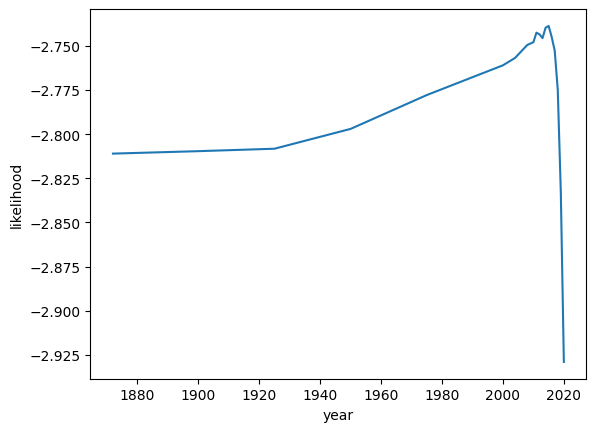

In [47]:
years = [
    1872, 1900, 1925, 1950, 1975, 2000,
    2004, 2008, 2010, 2011, 2012, 2013,
    2014, 2015, 2016, 2017, 2018, 2019,
    2020
]
train_until = 2020
test_from = 2021
test_until = 2022

likelihoods = []

for y in years:
    print("=======")
    print(y)
    print("=======")
    model = fit_model_between(y, train_until)
    likelihoods.append(test_model_between(model, test_from, test_until))


Text(0, 0.5, 'log likelihood (2021 - 2022)')

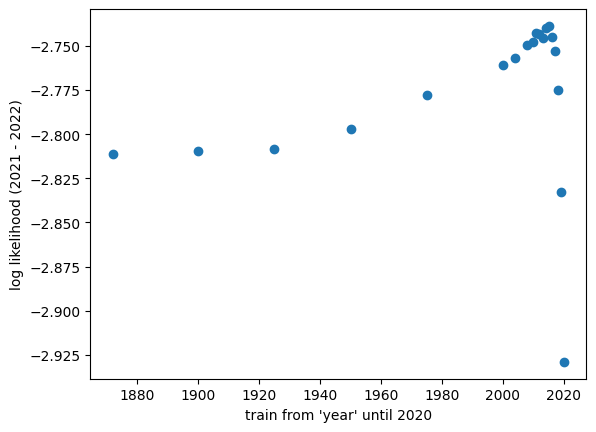

In [58]:
plt.plot(years, likelihoods, "o")
plt.xlabel(f"train from 'year' until {train_until}")
plt.ylabel(f"log likelihood ({test_from} - {test_until})")

In [50]:
pd.Series(likelihoods, index=years)

1872   -2.810997
1900   -2.809613
1925   -2.808227
1950   -2.796989
1975   -2.777815
2000   -2.760951
2004   -2.756748
2008   -2.749413
2010   -2.747872
2011   -2.742429
2012   -2.743396
2013   -2.745532
2014   -2.739667
2015   -2.738628
2016   -2.744843
2017   -2.752637
2018   -2.774900
2019   -2.832764
2020   -2.929056
dtype: float64

Max likelihood at 2015, i.e. when training with 6 full years of data.

So for World Cup 2022 may want to include 2016-2022 results.